In [10]:
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["font.size"] = 14
# pl.style.use("default")

In [12]:
import chronos as cr

#high proper motion star
s = cr.Star(toiid=1696, search_radius=10)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Target: TOI 1696


Querying Gaia DR2 catalog for ra,dec=(65.2807 48.8198) within 10.00 arcsec.
astrometric_excess_noise_sig=33.94 (>5 hints binarity).

astrometric_gof_al=24.49 (>20 hints binarity).
See https://arxiv.org/pdf/1804.11082.pdf

High proper-motion star:
(pmra,pmdec)=(12.93,-19.18) mas/yr
Found 1 references in Vizier with `ruwe`.


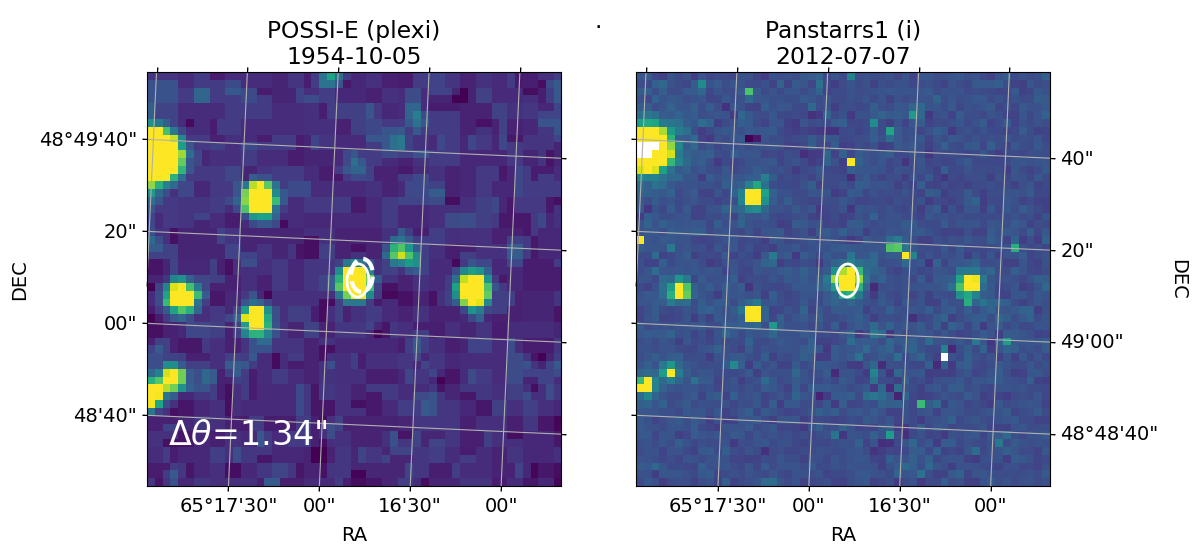

In [23]:
import numpy as np
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance
from astropy import units as u
from chronos import get_dss_data
from matplotlib.patches import Circle, FancyArrowPatch

survey1 = 'dss1' #old survey
survey2 = 'ps1' #'poss2ukstu_red'#new survey
color = 'w' #circle mark

fig, baseline = cr.plot_archival_images(ra=s.target_coord.ra.deg,
                                        dec=s.target_coord.dec.deg,
                                        survey1=survey1,
                                        survey2=survey2,
                                        filter='i',
                                        width=1.5,
                                        height=1.5,
                                        color=color,
                                        cmap='viridis',
                                        contrast=0.1,
                                        return_baseline=True
                                       )

gp = s.query_gaia_dr2_catalog(return_nearest_xmatch=True)
pmra, pmdec = gp['pmra'], gp['pmdec']
pm = np.hypot(pmra, pmdec) #mas/yr
offset = pm*baseline/1e3
text = r"$\Delta \theta$="+f"{offset:.2f}\""
ax = fig.axes[0]
ax.text(0.05, 0.1, text, transform=ax.transAxes, c=color, fontsize=24);

#current position
rv = 1 if np.isnan(gp.radial_velocity) else gp.radial_velocity
coord = SkyCoord(ra=gp.ra*u.deg, dec=gp.dec*u.deg, 
         pm_ra_cosdec=gp.pmra*u.mas/u.yr, 
         pm_dec=gp.pmdec*u.mas/u.yr,
         distance=Distance(parallax=gp.parallax*u.mas),
         radial_velocity=rv*u.km/u.second,
         equinox='J2015.5', 
         obstime='2015-05-01T0:0:0'
        )

# survey1 image
hdu1 = get_dss_data(ra=s.target_coord.ra.deg,
                   dec=s.target_coord.dec.deg,
                   survey=survey1, 
                   epoch="J2015.5", 
                   height=1, width=1, 
                   plot=False
                  )
survey1_obstime = hdu1.header['DATE-OBS']

# position in survey image
pos1 = coord.apply_space_motion(Time(survey1_obstime))
c1 = Circle((pos1.ra.deg, pos1.dec.deg), 
            #(s.target_coord.ra.deg, s.target_coord.dec.deg), 
            0.001, edgecolor=color, facecolor='none',
                  lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);

# survey image
# hdu2 = get_dss_data(ra=s.target_coord.ra.deg,
#                    dec=s.target_coord.dec.deg,
#                    survey=survey2, 
#                    epoch="J2015.5", 
#                    height=1, width=1, 
#                    plot=False
#                   )
# survey2_obstime = hdu2.header['DATE-OBS']
survey2_obstime = '2012-07-07'

# position in survey2 image
pos2 = coord.apply_space_motion(Time(survey2_obstime))
# c2 = Circle((pos2.ra.deg, pos2.dec.deg), 
#             0.001, edgecolor=color, facecolor='none',
#                   lw=3, transform=ax.get_transform('fk5'), ls='--')
# ax.add_patch(c2);

# ax.annotate(text,
#             xy=(pos1.ra.deg, pos1.dec.deg),
#             xytext=(pos2.ra.deg, pos2.dec.deg),
#             arrowprops={'arrowstyle': '->'},
#             transform=ax.get_transform('fk5')
#            )

add_arrow = False
if add_arrow:
    x_tail = pos2.ra.deg
    y_tail = pos2.dec.deg
    x_head = pos1.ra.deg
    y_head = pos1.dec.deg
    dx = x_head - x_tail
    dy = y_head - y_tail

    offset = 5/3600
    a = FancyArrowPatch((x_tail, y_tail-offset), 
                        (x_head, y_head+offset),
                        mutation_scale=30,
                        edgecolor=color, 
                        facecolor='w', 
                        lw=2, 
                        arrowstyle='simple',
                        transform=ax.get_transform('fk5')
                       )
    ax.add_patch(a);

In [24]:
fig.savefig("../paper/figures/archival_image.pdf", bbox_inches="tight")